# Análisis exploratorio de datos
## USGS
En este notebook se encuentra el análisis exploratorio de datos de sismos en Estados Unidos, Japón y México obtenidos de USGS. Se utilizó un periodo de 3 meses por las limitaciones del API, que solo permite 20K eventos por query.

In [1]:
# Importamos las librerias
import requests                     # hacer request a la pagina
import pandas as pd                 # dataframes
import matplotlib.pyplot as plt     # plots
import seaborn as sns               # plots
import numpy as np                  # manejo de arrays
import datetime                     # formato de fechas
from math import ceil               # redondeo

# Graficar con latitud y longitud
import geopandas as gpd                     
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.colors as colors


sns.set_style("darkgrid")

In [2]:
def read_usgs(url):
    # Hacemos un request porque hay json anidados
    data_json = requests.get(url).json()
    # el diccionario de features es el que tiene la infomación
    df = pd.json_normalize(data_json, record_path =['features'])

    return df

In [3]:
# url de https://earthquake.usgs.gov/earthquakes/search/
url_usa_con = 'https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime=2022-08-17%2000:00:00&endtime=2022-11-16%2023:59:59&maxlatitude=50&minlatitude=24.6&maxlongitude=-65&minlongitude=-125&minmagnitude=0&orderby=time-asc'
url_alaska = 'https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime=2022-08-17%2000:00:00&endtime=2022-11-16%2023:59:59&maxlatitude=71.511&minlatitude=53.409&maxlongitude=-141.029&minlongitude=-168.1&minmagnitude=0&orderby=time-asc'
url_japon = 'https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime=2022-08-17%2000:00:00&endtime=2022-11-16%2023:59:59&maxlatitude=45.629&minlatitude=29.554&maxlongitude=-213.864&minlongitude=-231.486&minmagnitude=0&orderby=time-asc'
url_mexico = 'https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime=2022-08-17%2000:00:00&endtime=2022-11-16%2023:59:59&maxlatitude=32.619&minlatitude=15.197&maxlongitude=-86.414&minlongitude=-117.352&minmagnitude=0&orderby=time-asc'

In [4]:
# USA
# Se divide porque tambien hay que tomaren cuenta alaska
df_usa_con = read_usgs(url_usa_con)
df_alaska = read_usgs(url_alaska)
df_usa = pd.concat([df_usa_con, df_alaska])
df_usa['country'] = 'USA'
# Japon
df_jp = read_usgs(url_japon)
df_jp['country'] = 'JP'
# Mexico
df_mx = read_usgs(url_mexico)
df_mx['country'] = 'MX'

Revisamos los datos faltantes por país

In [5]:
dfs = [df_usa, df_jp, df_jp]
for df in dfs:
    print(df['country'].unique())
    df_nulls = df.isnull().sum()
    print(df_nulls.loc[df_nulls > 30]*100/df.shape[0])

['USA']
properties.place      1.593907
properties.tz       100.000000
properties.felt      95.563756
properties.cdi       95.563756
properties.mmi       99.426822
properties.alert     99.905779
properties.nst       32.781093
properties.dmin      36.059202
properties.gap       32.781093
dtype: float64
['JP']
properties.tz       100.000000
properties.felt      84.324324
properties.cdi       84.324324
properties.mmi       98.378378
properties.alert     98.378378
dtype: float64
['JP']
properties.tz       100.000000
properties.felt      84.324324
properties.cdi       84.324324
properties.mmi       98.378378
properties.alert     98.378378
dtype: float64


Unimos en un solo dataset 

In [6]:
df = pd.concat([df_usa, df_jp, df_mx])
df.reset_index(inplace=True, drop=True)
df.head()

,type,id,properties.mag,properties.place,properties.time,properties.updated,properties.tz,properties.url,properties.detail,properties.felt,...,properties.nst,properties.dmin,properties.rms,properties.gap,properties.magType,properties.type,properties.title,geometry.type,geometry.coordinates,country
0,Feature,ci40326704,0.670000,"17km ESE of Anza, CA",1660694580810,1660697458929,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,...,21.0,0.074300,0.14,56.0,ml,earthquake,"M 0.7 - 17km ESE of Anza, CA",Point,"[-116.514, 33.4853333, 14.28]",USA
1,Feature,uw61872971,0.080000,"37 km NNE of Amboy, Washington",1660695475270,1660706738590,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,...,11.0,0.001333,0.11,137.0,ml,earthquake,"M 0.1 - 37 km NNE of Amboy, Washington",Point,"[-122.18466666666667, 46.199, 3.16]",USA
2,Feature,uu60510147,1.550000,"15 km SSE of Sunnyside, Utah",1660696150630,1660743363020,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,NaN,...,16.0,0.020550,0.17,183.0,ml,earthquake,"M 1.6 - 15 km SSE of Sunnyside, Utah",Point,"[-110.2993333, 39.429, -1.83]",USA
3,Feature,tx2022qaqd,3.803475,"17 km NNE of Hermleigh, Texas",1660697038390,1666923994040,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,14.0,...,24.0,0.076715,0.20,63.0,mlv,earthquake,"M 3.8 - 17 km NNE of Hermleigh, Texas",Point,"[-100.6637052, 32.76580811, 6.235961914]",USA
4,Feature,ci40326720,1.380000,"2km NNE of Cabazon, CA",1660697544620,1660751959270,None,https://earthquake.usgs.gov/earthquakes/eventp...,https://earthquake.usgs.gov/fdsnws/event/1/que...,0.0,...,52.0,0.100900,0.16,44.0,ml,earthquake,"M 1.4 - 2km NNE of Cabazon, CA",Point,"[-116.7756667, 33.9331667, 15.5]",USA


In [7]:
df.shape

(26494, 31)

In [8]:
# vemos los nulos totales
df_nulls = df.isnull().sum()
df_nulls*100/df.shape[0]

type                      0.000000
id                        0.000000
properties.mag            0.000000
properties.place          1.656979
properties.time           0.000000
properties.updated        0.000000
properties.tz           100.000000
properties.url            0.000000
properties.detail         0.000000
properties.felt          95.289500
properties.cdi           95.289500
properties.mmi           99.358345
properties.alert         99.852797
properties.status         0.000000
properties.tsunami        0.000000
properties.sig            0.000000
properties.net            0.000000
properties.code           0.000000
properties.ids            0.000000
properties.sources        0.000000
properties.types          0.000000
properties.nst           31.516570
properties.dmin          34.668227
properties.rms            0.000000
properties.gap           31.516570
properties.magType        0.000000
properties.type           0.000000
properties.title          0.000000
geometry.type       

In [9]:
# Cambiamos el nombre de las columna
# Quitamos properties de los nombres de columnas
lista_new = [palabra.replace('properties.', '') for palabra in df.columns.to_list()]
new_names = dict(zip(df.columns.to_list(), lista_new))
# Cambiamos los nombres
df.rename(new_names, axis='columns', inplace=True)

df.columns

Index(['type', 'id', 'mag', 'place', 'time', 'updated', 'tz', 'url', 'detail',
       'felt', 'cdi', 'mmi', 'alert', 'status', 'tsunami', 'sig', 'net',
       'code', 'ids', 'sources', 'types', 'nst', 'dmin', 'rms', 'gap',
       'magType', 'type', 'title', 'geometry.type', 'geometry.coordinates',
       'country'],
      dtype='object')

La descripción de cada variable, de acuerdo a la página de USGS (https://earthquake.usgs.gov/data/comcat/data-eventterms.php):

```
    type : diccionario del que proviene la información.
    id : identificador del evento.
    mag : magnitud.
    place : descripción textual de la región geográfica cercana al evento.
    tz : desfase de la zona horaria respecto a UTC en minutos en el epicentro del evento.
    url : enlace a la página del evento en USGS.
    detail : enlace a la fuente de detalles de GeoJSON desde una fuente de resumen de GeoJSON.
    felt : el número total de informes enviados a DYFI? sistema.
    cdi : la máxima intensidad reportada para el evento.
    mmi : la intensidad instrumental máxima estimada para el evento.
    alert : el nivel de alerta de la escala de impacto de terremotos de PAGER.
    status : indica si el evento ha sido revisado por un humano.
    tsunami : esta etiqueta se establece en "1" para grandes eventos en regiones oceánicas y "0" en caso contrario. La existencia o el valor de esta etiqueta no indica si realmente existió o existirá un tsunami.
    sig : un número que describe cuán significativo es el evento. Los números más grandes indican un evento más significativo. 
    net : ID de un contribuyente de datos. Identifica la red considerada como la fuente de información preferida para este evento.
    code : código de identificación asignado por, y único de, la fuente correspondiente para al evento.
    ids : una lista separada por comas de ID de eventos que están asociados a un evento.
    sources : una lista separada por comas de los colaboradores de la red.
    types : una lista separada por comas de los tipos de productos asociados a este evento.
    nst : el número total de estaciones sísmicas utilizadas para determinar la ubicación del terremoto.
    dmin : distancia horizontal desde el epicentro hasta la estación más cercana (en grados).
    rms : residual del tiempo de viaje de la media cuadrática (RMS), en segundos, usando todos los pesos. Este parámetro proporciona una medida del ajuste de los tiempos de llegada observados a los tiempos de llegada previstos para esta ubicación.
    gap : la brecha azimutal más grande entre estaciones azimutalmente adyacentes (en grados).
    magType : el método o algoritmo utilizado para calcular la magnitud preferida para el evento.
    type : tipo de evento sísmico.
    title : el título de la fuente.
    geometry.type : tipo de coordenada.
    geometry.coordinates : coordenada del sismo de la forma [longitud, latitud, profundidad].

```

### Formating
Tenemos que formatear las columnas para poder hacer la visualización. Esto lo haremos a continuación. Primero eliminamos las columnas que no vamos a utilizar, en general, las que tienen alto porcentaje de faltantes y las que tienen un solo valor único

In [10]:
df_nulls = df.isnull().sum()*100/df.shape[0]
print('Porcentaje de faltantes')
df_nulls[df_nulls > 50]

Porcentaje de faltantes


tz       100.000000
felt      95.289500
cdi       95.289500
mmi       99.358345
alert     99.852797
dtype: float64

In [11]:
df_uniques = df[df.columns[~df.columns.isin(['geometry.coordinates'])]].nunique()
print('Cantidad de unicos')
df_uniques[df_uniques == 1]

Cantidad de unicos


type             1
type             1
geometry.type    1
dtype: int64

In [12]:
columnas = ['type', 'alert', 'cdi', 'detail', 'felt', 'ids', 'mmi', 'sources', 'type', 'types', 'tz', 'geometry.type']
df.drop(columnas, axis='columns', inplace=True)

In [13]:
df.rename({'geometry.coordinates':'coordinates'}, axis='columns', inplace=True)
df.columns

Index(['id', 'mag', 'place', 'time', 'updated', 'url', 'status', 'tsunami',
       'sig', 'net', 'code', 'nst', 'dmin', 'rms', 'gap', 'magType', 'title',
       'coordinates', 'country'],
      dtype='object')

Ahora formateemos las que quedan. Empezamos separando `coordinates`

In [14]:
df[['longitude','latitude', 'depth']] = pd.DataFrame(df.coordinates.tolist(), index= df.index)
df.drop('coordinates', axis='columns', inplace=True)
df.columns

Index(['id', 'mag', 'place', 'time', 'updated', 'url', 'status', 'tsunami',
       'sig', 'net', 'code', 'nst', 'dmin', 'rms', 'gap', 'magType', 'title',
       'country', 'longitude', 'latitude', 'depth'],
      dtype='object')

In [15]:
# Revisamos los faltantes
df_nulls = df.isnull().sum()*100/df.shape[0]
print('Columnas con valores faltantes')
df_nulls[df_nulls > 0]


Columnas con valores faltantes


place     1.656979
nst      31.516570
dmin     34.668227
gap      31.516570
dtype: float64

De las columnas con valores faltantes, place es de strings y las demás son de floats. Rellenamos los valores faltantes de place con "No data" y por ahora dejaremos los faltantes en las demás como None.

In [16]:
df.place.fillna('No Data', inplace=True)

# Revisamos los faltantes
df_nulls = df.isnull().sum()*100/df.shape[0]
print('Columnas con valores faltantes')
df_nulls[df_nulls > 0]

Columnas con valores faltantes


nst     31.516570
dmin    34.668227
gap     31.516570
dtype: float64

Formateamos

In [17]:
# definimos funciones para formatear columnas de strings, floats e int

def format_str(df, column):
    '''Formatear strings colocando iniciales en mayuscula 
    y eliminando espacios en blanco a izq y der'''

    return df[column].astype(str).str.strip().str.title()

def format_int(df, column):
    '''Formatea columnas numéricas con valores nulos a int'''
    
    S = df[column].fillna(value=np.nan)
    # Al valor nulo se le asigna un numero que no se encuentre en la columna
    # y se convierte la columna en int
    S = S.fillna(-99999).astype(int)
    # se remplazan nuevamente los nulos
    S.replace(-99999, np.nan, inplace=True)
    
    return S

def format_float(df, column):
    '''Formatea columnas numéricas con valores nulos a float '''
    
    S = df[column].fillna(value=np.nan)
    # Al valor nulo se le asigna un numero que no se encuentre en la columna
    # y se convierte la columna en int
    S = S.fillna(-99999).astype(float)
    # se remplazan nuevamente los nulos
    S.replace(-99999, np.nan, inplace=True)
    
    return S

In [18]:
# agrupamos por tipo de dato
columnas_str = ['place', 'status', 'net', 'code', 'magType', 'title']
columnas_float = ['mag', 'dmin', 'rms', 'gap', 'latitude', 'longitude','depth']
columnas_int = ['tsunami', 'nst']

# formateamos con funciones 
for columna in columnas_str:
    df[columna] = format_str(df, columna)

for columna in columnas_float:
    df[columna] = format_float(df, columna)

for columna in columnas_int:
    df[columna] = format_int(df, columna)

In [19]:
def format_epoch_time(x):
    time = x/1000
    return datetime.datetime.fromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S.%f')
    
# Transformamos desde epoch a formato fecha-hora en str
df.time = df.time.apply(format_epoch_time)
df.updated = df.updated.apply(format_epoch_time)

# Transformamos a tipo datetime
df.time = pd.to_datetime(df.time)
df.updated = pd.to_datetime(df.updated)


In [22]:
# Lo guardamos para el reporte
df.to_csv('../datasets/usgs-reporte.csv', index=False)

Por último, volvemos a revisar cantidad de faltantes y de unicos

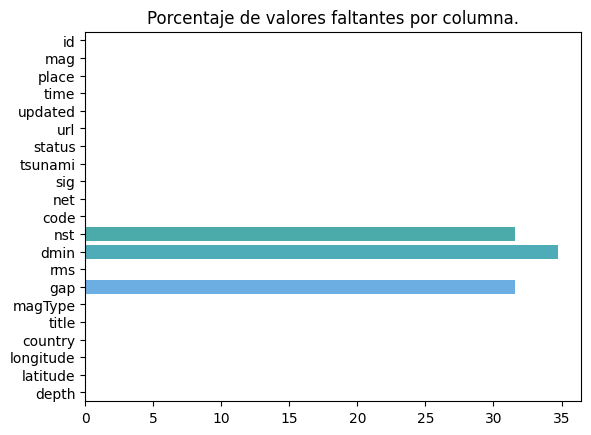

In [20]:
# Ploteamos el numero de faltantes por columna
sns.barplot(x = (df.isnull().sum()*100/df.shape[0]).values, y = df.columns)
plt.title('Porcentaje de valores faltantes por columna.');

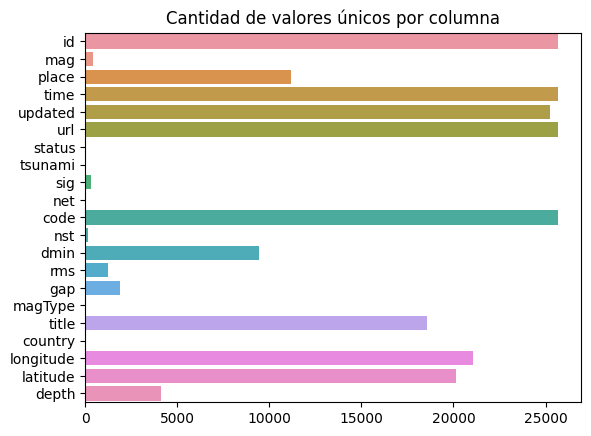

In [21]:
sns.barplot(x = df.nunique().values, y = df.columns)
plt.title('Cantidad de valores únicos por columna');

## Plots
Empezamos con el pairplot para ver distribuciones y correlaciones.

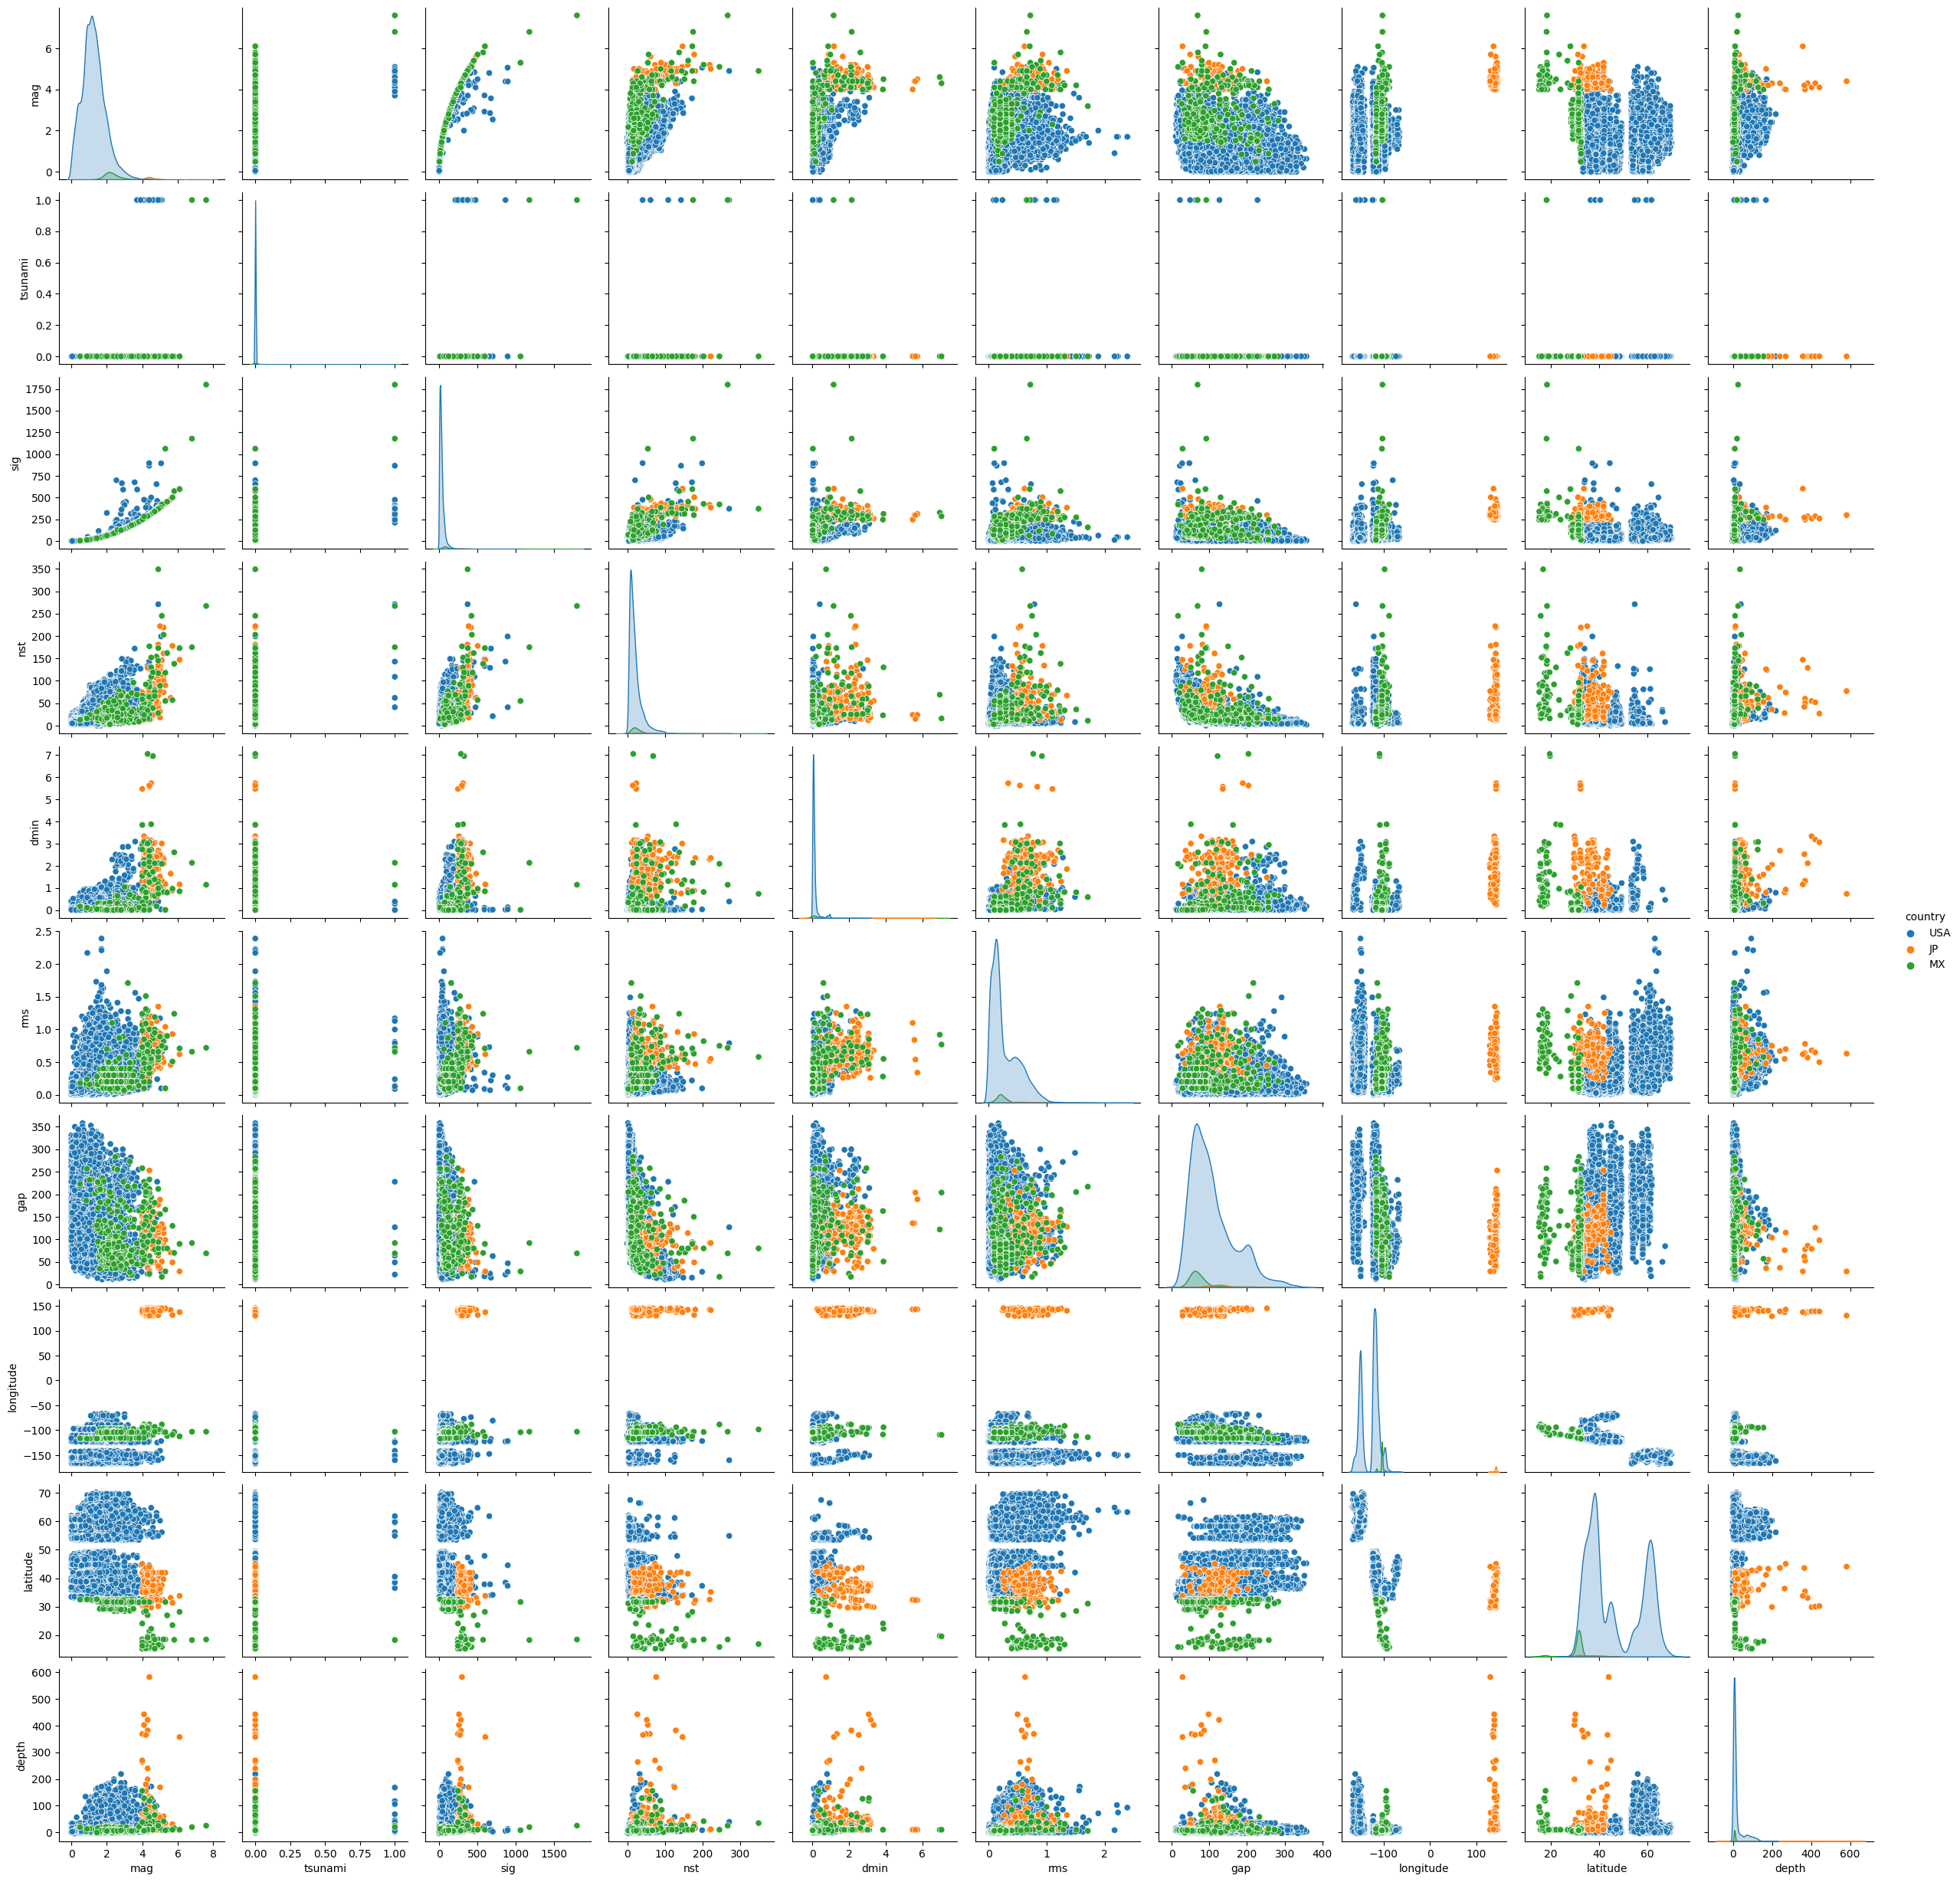

In [32]:
sns.pairplot(data=df, hue='country');

Existe una correlación entre `sig` y `mag` que indica que a mayores magnitudes, más significativo es el sismo, y las correlación usual entre latitud y longitud.

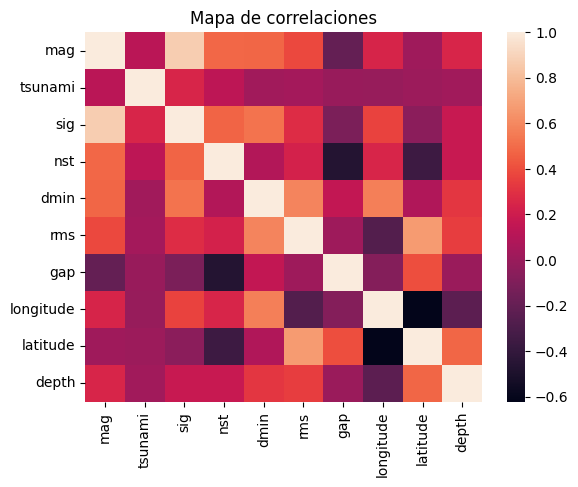

In [23]:
sns.heatmap(df.corr(numeric_only=True))
plt.title('Mapa de correlaciones');

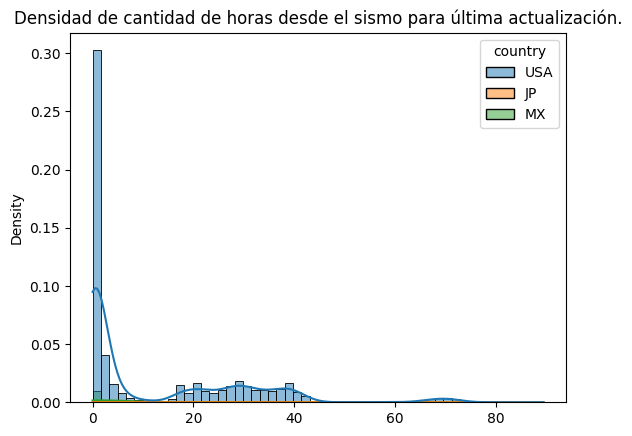

In [24]:
# Calculamos la cantidad de dias que se tardan en hacer la última actualización
df_hours = (df.updated-df.time).astype('timedelta64[h]')/24
sns.histplot(x = df_hours, hue=df.country, kde=True, stat="density")
plt.title('Densidad de cantidad de horas desde el sismo para última actualización.');

In [25]:
print('Cantidad de días promedio que toma hacer la última actualización: ')
for label in ['USA','JP','MX']:
    print(label, ' ', ceil(df_hours[df.country == label].mean()))

Cantidad de días promedio que toma hacer la última actualización: 
USA   13
JP   32
MX   12


Tenemos mas sismos de USA que de Japón y México

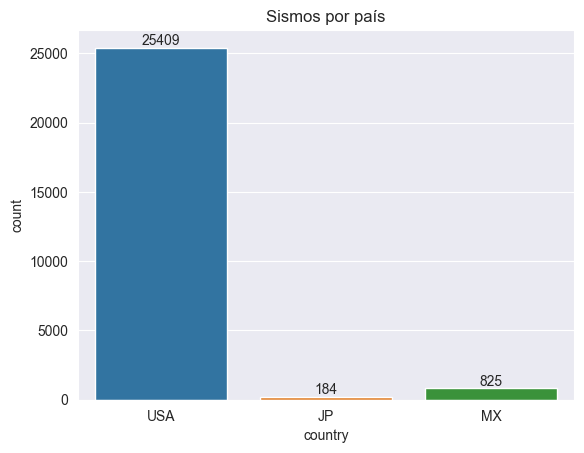

In [60]:
ax = sns.countplot(df, x='country')
ax.bar_label(ax.containers[0])
plt.title('Sismos por país');

Lo podemos visualizar en el mapa y al mismo tiempo ver las magnitudes, profundidad y alertas de tsunami

In [26]:
# https://towardsdatascience.com/plotting-maps-with-geopandas-428c97295a73
# Escogemos el mapa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Creamos el objeto geodataframe
crs = 'EPSG:4326'
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(df, 
                          crs = crs, 
                          geometry = geometry)

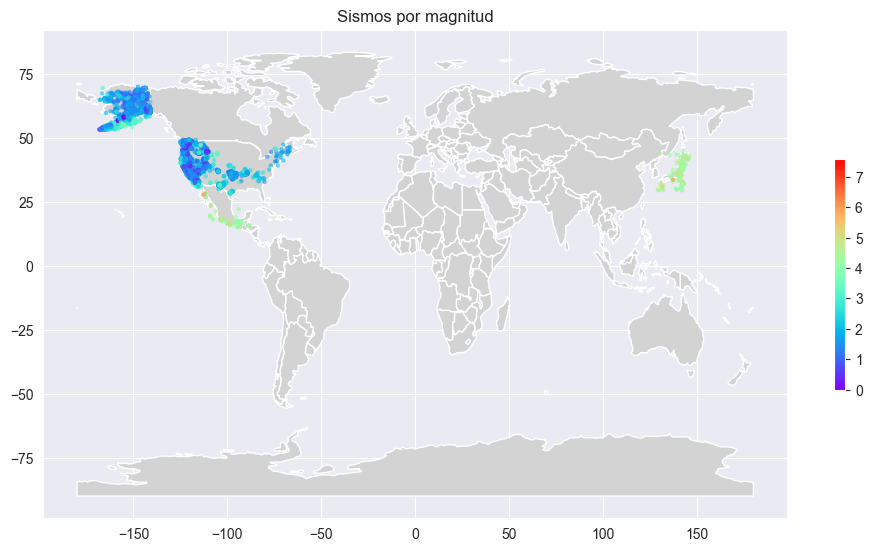

In [84]:
# por magnitud
# creamos la figura
fig, ax = plt.subplots(figsize = (12,10))

world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

geo_df.plot(column = 'mag', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 5, alpha=0.5)
            
ax.set_title('Sismos por magnitud');

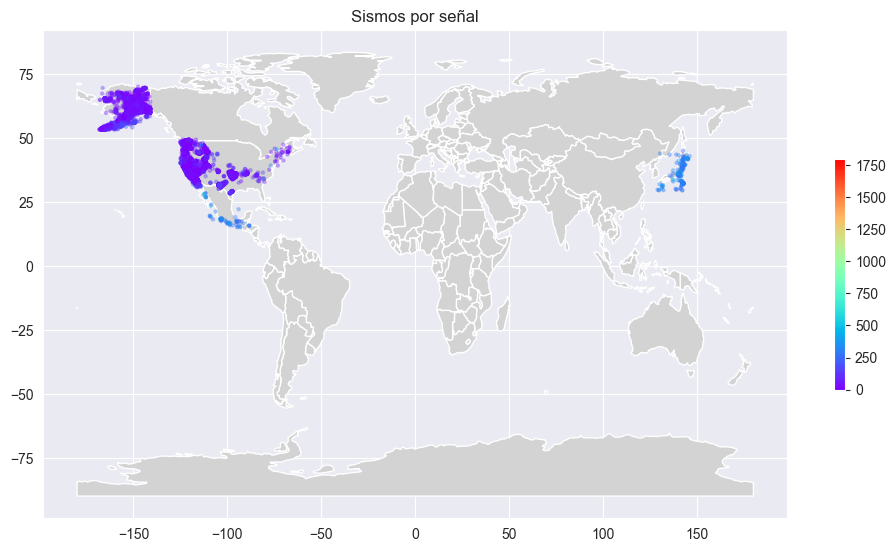

In [85]:
# por señal de alerta
fig, ax = plt.subplots(figsize = (12,10))

world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

geo_df.plot(column = 'sig', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 5, alpha=0.3)
            
ax.set_title('Sismos por señal');

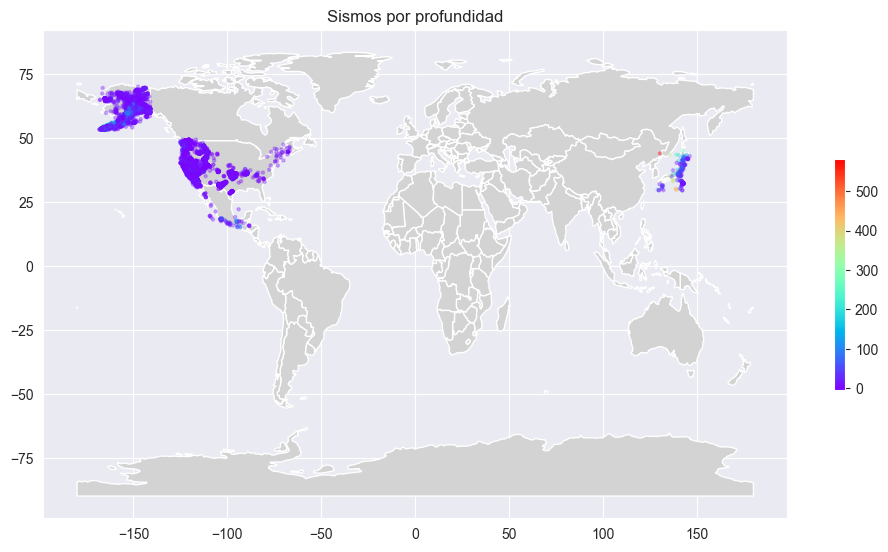

In [96]:
# por profundida
fig, ax = plt.subplots(figsize = (12,10))

world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

geo_df.plot(column = 'depth', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 5, alpha=0.3)
            
ax.set_title('Sismos por profundidad');

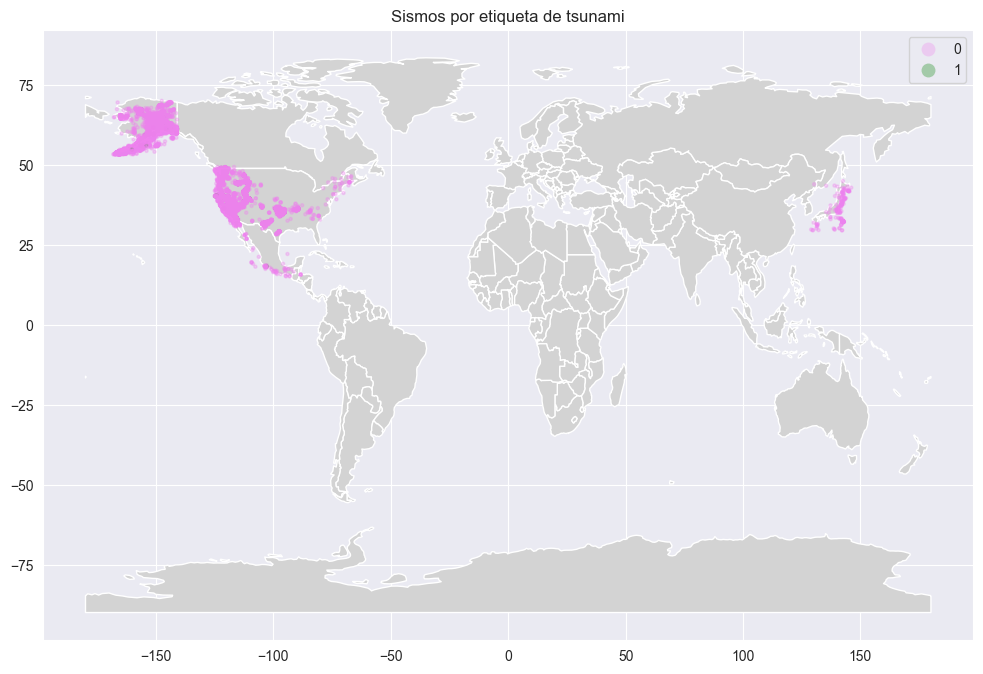

In [121]:
# Por tsunami
fig, ax = plt.subplots(figsize = (12,10))

world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

geo_df.plot(column = 'tsunami', ax=ax, cmap=colors.ListedColormap(['violet','green']),
            legend = True, categorical=True,
            markersize = 5, alpha=0.3)
            
ax.set_title('Sismos por etiqueta de tsunami');

Hay pocos sismos con etiqueta de tsunami

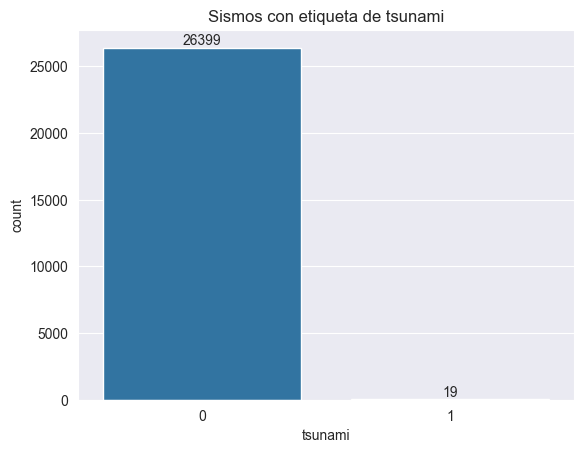

In [94]:
ax = sns.countplot(df, x='tsunami')
ax.bar_label(ax.containers[0])
plt.title('Sismos con etiqueta de tsunami');

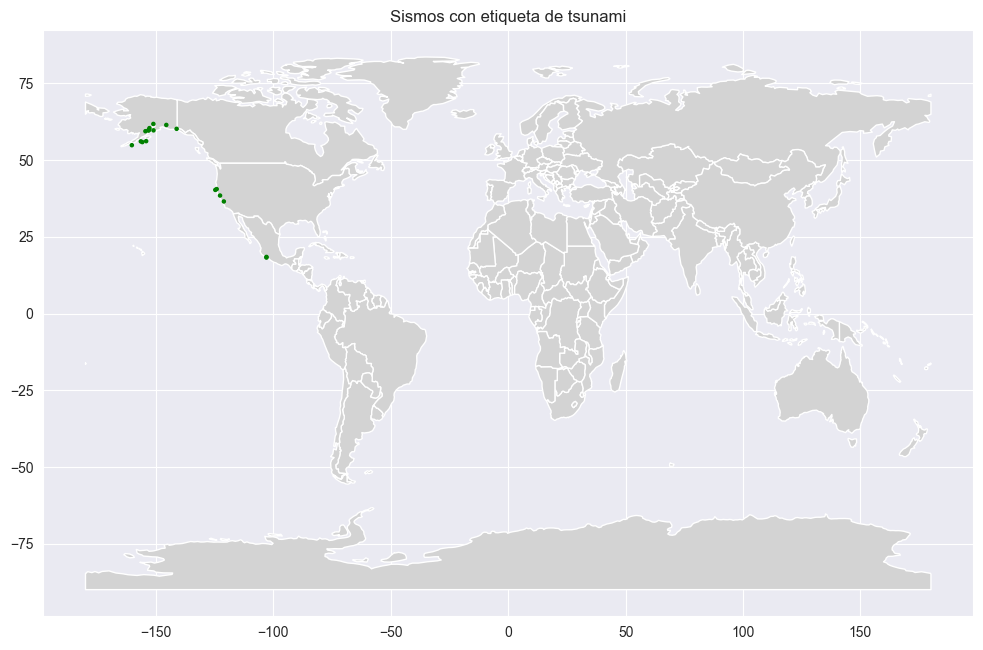

In [125]:
# Graficamos solo los que tienen etiqueta tsunami
#geo_df['tsunami'] = geo_df['tsunami']
fig, ax = plt.subplots(figsize = (12,10))

world.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')

geo_df[geo_df.tsunami==1].plot(column = 'tsunami', ax=ax, cmap=colors.ListedColormap(['green']),
            legend = False, 
            markersize = 5, alpha=1)
            
ax.set_title('Sismos con etiqueta de tsunami');

### Variable cualitativas
Vamos a estudiar un poco las variables cualitativas o de metadata de los datos principales

In [89]:
def top_ten(df, column, axis=None):
    '''Plot de los 10 valores principales agrupados por cuenta'''

    plane = df.pivot_table(index = [column], aggfunc ='size').sort_values(ascending=False)
    
    # Opcion para ejes
    if axis:
        sns.barplot(ax=axis, x=plane.values[:10], y=plane.index[:10])
    else:
        sns.barplot(x=plane.values[:10], y=plane.index[:10])
        plt.title('10 {} con más accidentes'.format(column))
        plt.show()
        plt.close()

El lugar en donde más han sucedido sismos en los últimos meses está en California, USA.

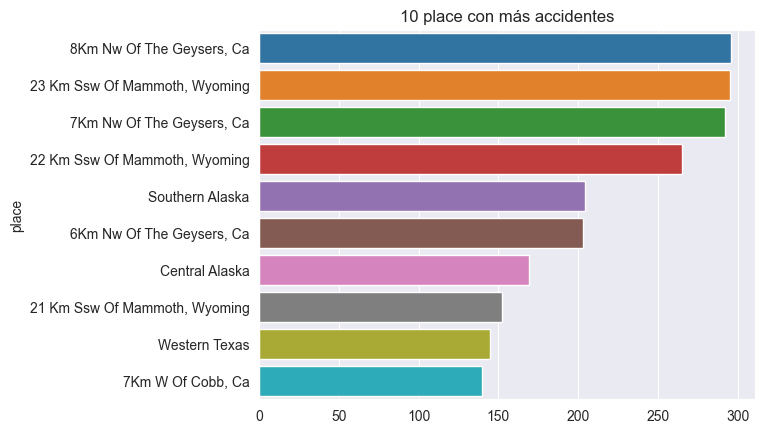

In [90]:
top_ten(df[df.place != 'No Data'], column='place')

La mayoría de los eventos registrados han sido revisados por humanos, lo que le da confiabilidad a los datos

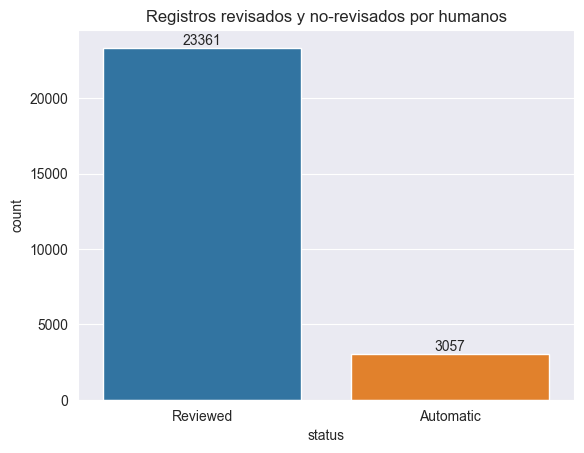

In [91]:
ax = sns.countplot(df, x='status')
ax.bar_label(ax.containers[0])
plt.title('Registros revisados y no-revisados por humanos');

Los algoritmos más utilizados para calcular la magnitud son ml y md:
- **Ml**: La relación de magnitud original definida por Richter y Gutenberg en 1935 para terremotos locales.
- **Md**: Basado en la duración de la sacudida medida por el decaimiento temporal de la amplitud del sismograma. A veces, la única magnitud disponible para eventos muy pequeños

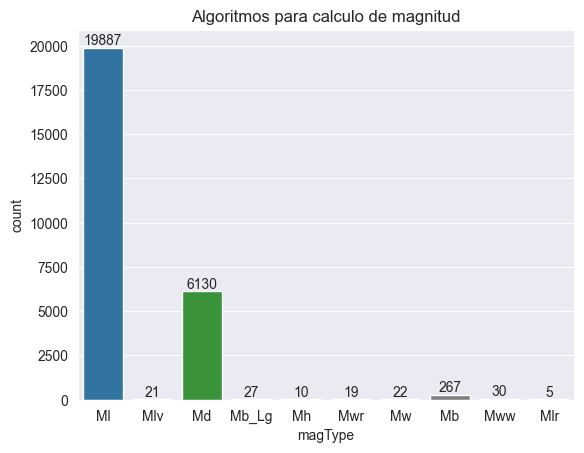

In [97]:
ax = sns.countplot(df, x='magType')
ax.bar_label(ax.containers[0])
plt.title('Algoritmos para calculo de magnitud');

Sin embargo, para calcular la magnitud de sismos con magnitudes mayores a 3 se suelen usar otros algoritmos

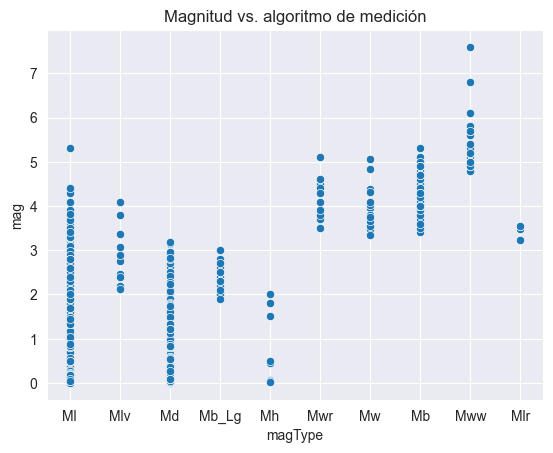

In [106]:
sns.scatterplot(df, x='magType', y='mag')
plt.title('Magnitud vs. algoritmo de medición');